<a href="https://colab.research.google.com/github/BrunoKedzierski/Neural-Network-From-Scratch/blob/main/Neural_Network_implementatnion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
import math

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40, stratify=y)

# Neural network diagram
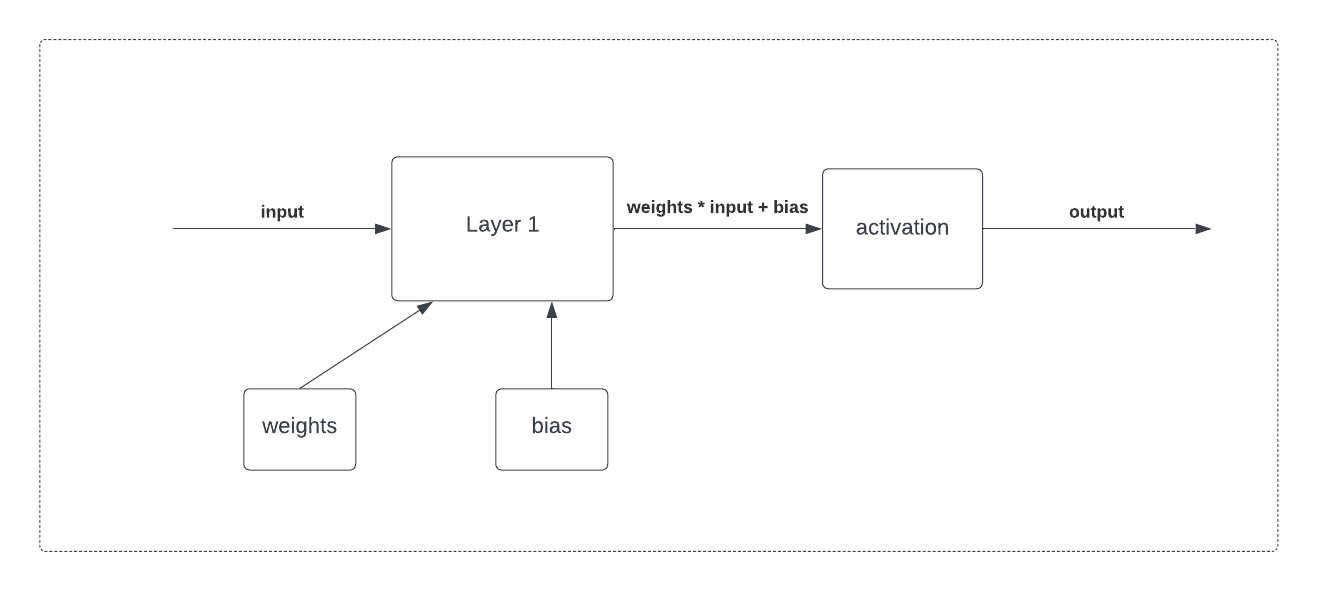


---


Backpropagation


**Goal - find the derivative of the error with respect to a given weights and biases of layer *j* :**

\begin{eqnarray} 
  \frac{\partial E}{\partial w_{j}}, 
  \frac{\partial E}{\partial b_{j}}  
\end{eqnarray}

**Equation 1. For layer *j*, this derivative looks as follows:**
\begin{eqnarray} 
  \frac{\partial E}{\partial w_{j}} =   \frac{\partial E}{\partial Y_{j}} * \frac{\partial Y}{\partial W_{j}}
\\
\frac{\partial E}{\partial b_{j}} =   \frac{\partial E}{\partial Y_{j}} 
\end{eqnarray}
Where Y is the layer output.

**Equation 2. The error needs to be passed to the previous layer, to do so we calculate the Error with respect to the layer input**
\begin{eqnarray} 
  \frac{\partial E}{\partial X_{j}} =   \frac{\partial E}{\partial Y_{j}} *  \frac{\partial W_{j}}{\partial X_{j}}
\end{eqnarray}
Where X is the input the layer. 



**Equation 3. In the activation layer ther are no trainable parameters - we need to compute only the error with respect to input**
\begin{eqnarray} 
  \frac{\partial E}{\partial X_{j}} =   \frac{\partial E}{\partial Y_{j}} *  \phi'(X_{j})
\end{eqnarray}
Where Φ'(x) is the dervivative of activation with respect to input.

**


**Note, that the input of layer j is the output of layer j-1. Hence:**
\begin{eqnarray} 
\frac{\partial E}{\partial Y_{j-1}} = \frac{\partial E}{\partial X_{j}}
\end{eqnarray}

**Update rule**
\begin{eqnarray} 
w_{j} ← w_{j} - α * \frac{\partial E}{\partial w_{j}}
\end{eqnarray}
where α is the learning rate

In [3]:
#Base dense layer class
class Dense_Layer():
  def __init__(self,input_size, output_size, learning_rate):
    self.weights = np.random.randn(output_size, input_size) * np.sqrt(2/input_size)
    self.biases = np.random.randn(output_size,1)
    self.learning_rate = learning_rate
  
  def forward_pass(self,x):
    self.input = x
    return np.dot(self.weights, self.input) + self.biases 
  
  def backwards_pass(self, ey):
    self.ew = np.dot(ey, self.input.T) #equation 1
    self.eb = ey #equation 1
    self.ex = np.dot(self.weights.T, ey) #equation 2
    self.update()
    return self.ex

  #update rule  
  def update(self):
    self.weights -= self.ew * self.learning_rate
    self.biases -= self.eb * self.learning_rate


class Activation():
    def __init__(self,activation_function, activation_der):
      self.activation_function = activation_function
      self.activation_der = activation_der
    def forward_pass(self, x):
      self.input = x
      return self.activation_function(self.input)
    def backwards_pass(self, ey):
      return np.multiply(ey ,self.activation_der(self.input)) #equation 3


def MSE(true_val, predicted_val):
  return np.mean(np.subtract( predicted_val,true_val)**2)
def MSE_der(true_val, predicted_val):
  return 2 * np.subtract(predicted_val, true_val)/np.size(true_val)


def binary_cross_entropy(y_true, y_pred):
    return  np.sum(np.maximum(y_pred, 0) - y_pred*y_true + np.log(1+ np.exp(- np.abs(y_pred))))
    

def binary_cross_entropy_derivative(y_true, y_pred):
   return ((1/(1+np.exp(- y_pred))) - y_true)


# Prepare basic activation functions

In [4]:
relu = lambda x: np.maximum(0, x)
relu_der = lambda x : np.where(x > 0, 1, 0)
sigmoid = lambda x:  1 / (1 + np.exp(-x))
sigmoid_der = lambda x : sigmoid(x) * (1 - sigmoid(x))
tanh = lambda x : np.tanh(x)
tanh_der = lambda x : 1 - np.tanh(x)**2

# Test the neural network on Iris dataset
The neural network scores 98% on Iris test data

In [7]:
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
#load data
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40, stratify=y)

X = np.reshape(X_train, (len(X_train),4,1))

#One hot encode targets
Y = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
Y = Y.reshape((len(Y),3,1))

#define the network
network = [
    Dense_Layer(4,4,0.01),
    Activation(relu, relu_der),
     Dense_Layer(4,3,0.01),
    Activation(relu, relu_der),
    Dense_Layer(3,3,0.01),
    Activation(tanh, tanh_der)
]

#Train network 
for epoch in range(1000):
  error = 0
  for x, y in zip(X,Y):
    out = x
    for l in network:
      out = l.forward_pass(out)
    error += MSE(y, out)

    grad = MSE_der(y, out)
    for l in reversed(network):
      grad = l.backwards_pass(grad)
  error = error/len(Y)
  print(f"Epoch {epoch}, error {error}")





X = np.reshape(X_test, (len(X_test),4,1))
Y = np.reshape(y_test, (len(y_test),1,1))
Y = one_hot_encoder.fit_transform(np.array(Y).reshape(-1, 1))

#Test the network
correct = 0
for x, y in zip(X,Y):
  out = x
  for l in network:
    out = l.forward_pass(out)
  max_idx = np.argmax(out)
  out_arr = np.zeros_like(out)
  out_arr[max_idx] = 1
  if (out_arr.ravel()==y).all():
    correct+= 1
    
print(f"accuracy {correct/len(Y)}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 0, error 0.8090912264122168
Epoch 1, error 0.7807508700724103
Epoch 2, error 0.7603527494932837
Epoch 3, error 0.7471905233499463
Epoch 4, error 0.7372663605414869
Epoch 5, error 0.7292151554906308
Epoch 6, error 0.7223101963723917
Epoch 7, error 0.7190750430182292
Epoch 8, error 0.7168101305585758
Epoch 9, error 0.7151710049119266
Epoch 10, error 0.7138589433094942
Epoch 11, error 0.7126893058842831
Epoch 12, error 0.7112788275122987
Epoch 13, error 0.709572738557474
Epoch 14, error 0.7074403350084364
Epoch 15, error 0.7050663024814563
Epoch 16, error 0.7023565604419345
Epoch 17, error 0.6988197180672935
Epoch 18, error 0.6934416922975107
Epoch 19, error 0.6849484012592485
Epoch 20, error 0.6672759655979145
Epoch 21, error 0.5771076204841519
Epoch 22, error 0.2921875440118531
Epoch 23, error 0.25285593308609056
Epoch 24, error 0.18731350734987406
Epoch 25, error 0.162097668284043
Epoch 26, error 0.15412670478430482
Epoch 27, error 0.1495190441166686
Epoch 28, error 0.14604486268

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
